In [20]:

import logging
import os
import pickle
import warnings

import category_encoders as ce
import lightgbm as lgb
import mlflow
import numpy as np
import pandas as pd
import yaml
from sklearn import metrics
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
# from sklearn.impute import KNNImputer
from sklearn.preprocessing import (
    Normalizer,
    FunctionTransformer
)
from sklearn.ensemble import RandomForestClassifier

In [5]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [71]:
warnings.filterwarnings("ignore")

with open("../params.yaml", "rb") as f:
    params = yaml.load(f, yaml.FullLoader)

mlflow.set_tracking_uri(params["ml_flow"]["MLFLOW_TRACKING_URI"])
os.environ["MLFLOW_TRACKING_USERNAME"] = params["ml_flow"][
    "MLFLOW_TRACKING_USERNAME"
]
os.environ["MLFLOW_TRACKING_PASSWORD"] = params["ml_flow"][
    "MLFLOW_TRACKING_PASSWORD"
]
# mlflow.set_experiment("imputation_by_label_experiments")
# mlflow.set_experiment("simple_imputation_experiments")
mlflow.set_experiment("all_binary_experiments")
# mlflow.sklearn.autolog()
# mlflow.xgboost.autolog()
mlflow.lightgbm.autolog()

In [2]:
# train_data = pd.read_parquet(
#     "../data/processed/chrome/08_12_2022/train_set_all_binary.parquet.gzip"
# )
# test_data = pd.read_parquet(
#     "../data/processed/chrome/08_12_2022/test_set_all_binary.parquet.gzip"
# )

train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
)
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_processed.parquet.gzip"
)

# test_data = pd.read_parquet(
#     "../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip"
#     )

# test_data = pd.read_parquet(
#     "../data/processed/brave/08_12_2022/test_set_all_processed.parquet.gzip"
#     )

In [53]:
test_tracker = test_data[['tracker']]

In [54]:
test_tracker

,tracker
0,0
1,0
2,0
3,0
4,0
...,...
564658,0
564659,0
564660,0
564661,0


In [3]:
train_data = train_data.iloc[:, 4:-2]
test_data = test_data.iloc[:, 4:-2]

In [56]:
test_data['tracker'] = test_tracker

In [5]:
# train_data.reset_index(inplace=True, drop=True)
# test_data.reset_index(inplace=True, drop=True)

In [4]:
for elem in train_data.iloc[:, :-1].columns.values.tolist():
    train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)

<ipython-input-4-8c2879514956>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f"{elem}_binary"] = np.where(train_data[elem].isnull(), 0, 1)
<ipython-input-4-8c2879514956>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f"{elem}_binary"] = np.where(test_data[elem].isnull(), 0, 1)
<ipython-input-4-8c2879514956>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

In [6]:
train_data = train_data.iloc[:, 150:]
test_data = test_data.iloc[:, 150:]

for elem in train_data.columns.values.tolist():
    train_data[elem] = train_data[elem].astype("uint8")
    test_data[elem] = test_data[elem].astype("uint8")


def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
            temp_cols[0:index_col]
            + temp_cols[index_col + 1:]
            + temp_cols[index_col: index_col + 1]
    )
    return new_col_order


reordered_cols = label_as_last_column(train_data)
train_data = train_data[reordered_cols]
test_data = test_data[reordered_cols]

In [60]:
test_data

,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,x-robots-tag_binary,...,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary,tracker
0,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564658,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564659,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564660,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564661,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# %%time
# dummy_clf = DummyClassifier(strategy="most_frequent", random_state=10)
# dummy_clf.fit(X_train, y_train)
# dummy_clf.score(X_train, y_train)

2022/11/16 11:12:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '495c4df3f3154b4897180cebe48f7691', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


CPU times: user 802 ms, sys: 206 ms, total: 1.01 s
Wall time: 7.77 s


0.7157431508360171

In [22]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized_no_imp.parquet.gzip"
)
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized_no_imp.parquet.gzip"
)

In [23]:
def impute_value(element):
    if element in ["content-length", "age"]:
        value = int(
            train_data[element].median()
        )
        imputed_values_dict[0].append({element: value})
        train_data[
            element
        ] = train_data[element].fillna(
            value
        )

    if element in list_of_categorical_cols:
        value = (
            train_data[element].mode().iloc[0]
        )
        imputed_values_dict[0].append({element: value})
        train_data[
            element
        ] = train_data[element].fillna(
            value
        )


list_of_categorical_cols = list(
    train_data.select_dtypes("category").columns.values.tolist()
)
imputed_values_dict = {0: []}
for elem in train_data.iloc[:, :19].columns.values.tolist():
    impute_value(elem)
for elem in imputed_values_dict[0]:
    ((key, value),) = elem.items()
    if key in list_of_categorical_cols:
        if value not in test_data[key].cat.categories:
            test_data[key].cat.add_categories("Missing", inplace=True)
    test_data[key] = test_data[key
    ].fillna(value)

In [24]:
model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="log_loss",
    max_features=None,
)

# model = KNeighborsClassifier(n_jobs=-1)
# model = DecisionTreeClassifier()
# model = GradientBoostingClassifier()
# model = HistGradientBoostingClassifier()
# model = xgb.XGBClassifier()
# model = lgb.LGBMClassifier(class_weight="balanced")
# model = CatBoostClassifier(thread_count=-1)
# model = MLPClassifier()
# model = LogisticRegression(n_jobs=-1, random_state=10)
# model = GaussianNB()

In [8]:
def calculate_metrics(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print("Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Model auc score : {0:0.4f}".format(auc_score))
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print(metrics.classification_report(y_test, y_pred))

    disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, name="Random Forest"
    )
    disp_3 = metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
    mlflow.log_figure(disp_1.figure_, "cm.png")
    mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    mlflow.log_figure(disp_3.figure_, "roc.png")

In [26]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

del train_data
del test_data

Model accuracy score : 0.9750
Model log-loss score : 0.1466
Model auc score : 0.9689
Balanced accuracy score : 0.9689
F1 score : 0.9560
Precision score : 0.9575
Recall score : 0.9546
Matthews correlation coefficient score : 0.9386
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     48671
           1       0.96      0.95      0.96     19330

    accuracy                           0.98     68001
   macro avg       0.97      0.97      0.97     68001
weighted avg       0.98      0.98      0.98     68001



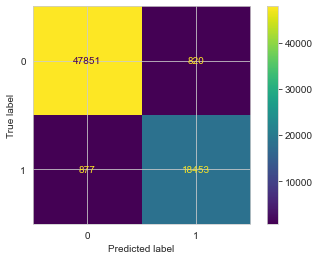

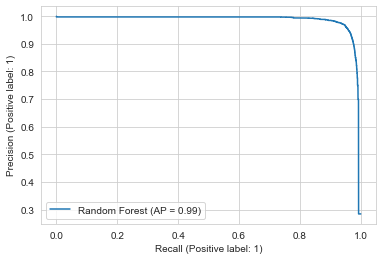

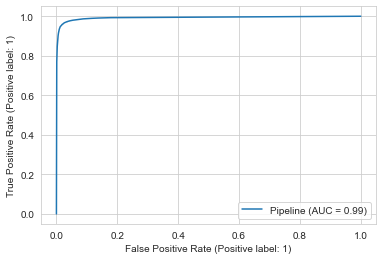

In [27]:
numeric_transformer = Pipeline(steps=[("scaler", FunctionTransformer(np.log1p))])
norm_transformer = Pipeline(steps=[("norm_scaler", Normalizer())])
# minmax_transformer = Pipeline(steps=[("mmscaler", MinMaxScaler(feature_range=[-1, 1]))])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ce.WOEEncoder(), selector(dtype_include="category")),
        ("num", numeric_transformer, ['content-length']),
        ('age', norm_transformer, ['age']),
    ]
)

clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

clf.fit(X_train, y_train["tracker"])
calculate_metrics(X_test, y_test)

Model accuracy score : 0.9115
Model log-loss score : 0.2423
Model auc score : 0.9055
Balanced accuracy score : 0.9055
F1 score : 0.8514
Precision score : 0.8147
Recall score : 0.8915
Matthews correlation coefficient score : 0.7902
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     48671
           1       0.81      0.89      0.85     19330

    accuracy                           0.91     68001
   macro avg       0.88      0.91      0.89     68001
weighted avg       0.92      0.91      0.91     68001



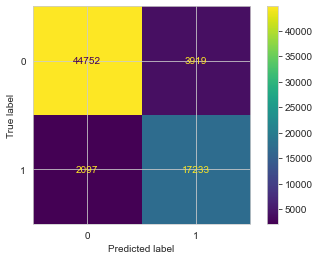

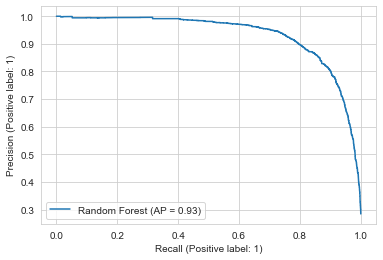

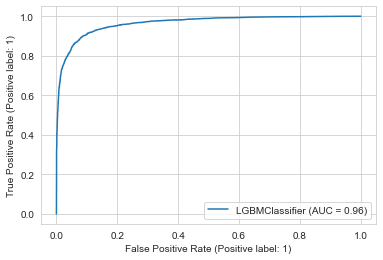

In [77]:
with mlflow.start_run():
    clf = lgb.LGBMClassifier(class_weight="balanced")

    # numeric_transformer = Pipeline(steps=[("scaler", FunctionTransformer(np.log1p))])
    # norm_transformer = Pipeline(steps=[("norm_scaler", Normalizer())])
    # # minmax_transformer = Pipeline(steps=[("mmscaler", MinMaxScaler(feature_range=[-1, 1]))])
    #
    # preprocessor = ColumnTransformer(
    #     transformers=[
    #         ("cat", ce.WOEEncoder(), selector(dtype_include="category")),
    #         ("num", numeric_transformer, ['content-length']),
    #         ('age', norm_transformer, ['age']),
    #     ]
    # )
    #
    # clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    clf.fit(X_train, y_train["tracker"])
    calculate_metrics(X_test, y_test)
mlflow.end_run()

In [44]:
filename = "nb_binary.sav"
pickle.dump(model, open(f'../models/chrome/08_12_2022/{filename}', 'wb'))

In [14]:
test_data = pd.read_parquet(
    "../data/processed/firefox/08_12_2022/test_set_01_featurized.parquet.gzip"
)

In [17]:
def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = (
            temp_cols[0:index_col]
            + temp_cols[index_col + 1:]
            + temp_cols[index_col: index_col + 1]
    )
    return new_col_order


reordered_cols = label_as_last_column(test_data)
test_data = test_data[reordered_cols]

In [37]:
X_test_2, y_test_2 = test_data_wo_duplicates.iloc[:, :-1], test_data_wo_duplicates[["tracker"]]

In [21]:
logged_model = 'runs:/40c7bb184746499a82f08cbafdc81c02/model'
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [32]:
def calculate_metrics_2(data, y_true):
    y_pred = loaded_model.predict(data)
    # pred_probs = loaded_model.predict_proba(data)
    # score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print("Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_true, y_pred)))
    # print("Model log-loss score : {0:0.4f}".format(score))
    print("Model auc score : {0:0.4f}".format(auc_score))
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print(metrics.classification_report(y_true, y_pred))

    disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
        loaded_model, data, y_test_2, name="Random Forest"
    )
    disp_3 = metrics.RocCurveDisplay.from_estimator(loaded_model, data, y_true)
    mlflow.log_figure(disp_1.figure_, "cm.png")
    mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    mlflow.log_figure(disp_3.figure_, "roc.png")

Model accuracy score : 0.9994
Model auc score : 0.9993
Balanced accuracy score : 0.9993
F1 score : 0.9987
Precision score : 0.9984
Recall score : 0.9989
Matthews correlation coefficient score : 0.9983
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221886
           1       1.00      1.00      1.00     58622

    accuracy                           1.00    280508
   macro avg       1.00      1.00      1.00    280508
weighted avg       1.00      1.00      1.00    280508



ValueError: PrecisionRecallDisplay.from_estimator only supports classifiers

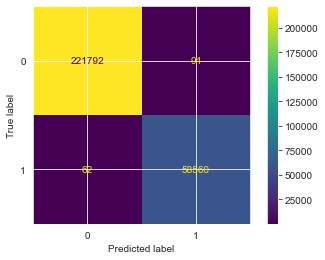

In [38]:
calculate_metrics_2(X_test_2, y_test_2)

In [36]:
test_data_wo_duplicates = test_data[~test_data.iloc[:, 6:-1].duplicated(keep="first")].reset_index(drop=True)